In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import galsim
import numpy as np
import fpfs
import matplotlib.pyplot as plt
import time

import batsim.pltutil as batplot
import batsim.stamp as batstamp
import batsim.transforms as batforms

0.008640494697709935
112


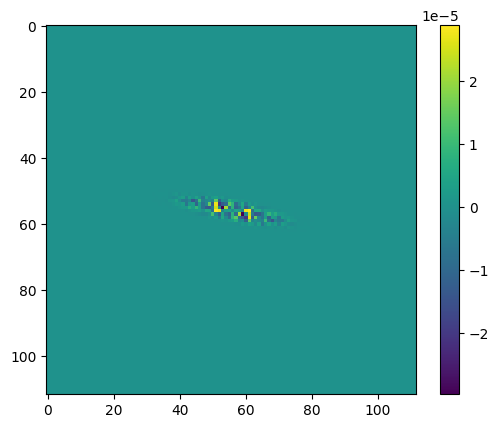

In [8]:
hlr = 0.01
flux = 40

gsparams = galsim.GSParams(maximum_fft_size=100000, folding_threshold=1e-8)

gal = galsim.Sersic(n=0.5, half_light_radius=hlr, flux=flux, gsparams=gsparams)

cosmos = galsim.COSMOSCatalog()
rng = galsim.BaseDeviate(54)
gal = cosmos.makeGalaxy(gal_type='parametric', noise_pad_size=0, rng=rng, n_random=1, gsparams=gsparams)

scale = gal.nyquist_scale
nn = gal.getGoodImageSize(scale)
print(scale)
print(nn)
# if nn > 1024:
#     nn = 1024

im_stamp = batstamp.Stamp(nn=nn, scale=scale, centering='fpfs')

# IA = batforms.IaTransform(A=0.2, beta=0., phi=np.radians(0), hlr=hlr, scale=scale, center=[-0.5*scale, -0.5*scale])
# gamma1, gamma2 = IA.get_g1g2(0,0)

gamma1 = 0.2
gamma2 = 0.
kappa = 0.

mu = 1/((1-kappa)**2 - gamma1**2 - gamma2**2)
gals = gal.lens(g1=gamma1, g2=gamma2, mu=mu)
gal_im = gals.shift(0.5*scale, 0.5*scale).drawImage(nx=nn, ny=nn, scale=scale, method='sb')

Lens = batforms.LensTransform(gamma1=gamma1, gamma2=gamma2, kappa=kappa, center=None)
im_stamp.transform_grids(Lens)
bats = im_stamp.sample_galaxy(gal)

plt.imshow(bats-gal_im.array)
plt.colorbar()

no_psf_residual = bats - gal_im.array

0.019896268844604492
4.292183


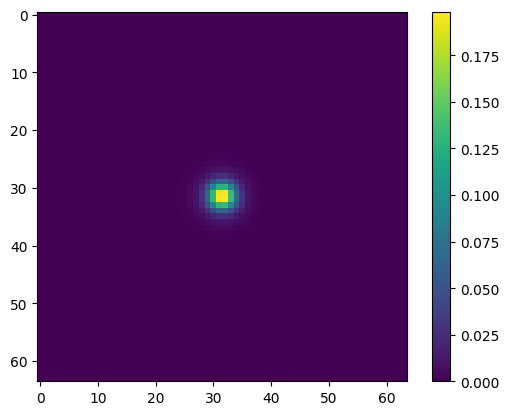

In [9]:
from scipy.signal import convolve2d

# psf_obj = galsim.Moffat(beta=3.5, fwhm=0.6, flux=1.0)
# psf_arr = psf_obj.shift(-0.5*scale, -0.5*scale).drawImage(nx=64, ny=64, scale=scale, method='no_pixel').array

# print(np.sum(bats)+np.sum(psf_arr))
# psf_arr /= np.sum(psf_arr)

# print(np.sum(bats))
# # Convolution of the galaxy with the PSF
# conv_im = convolve2d(bats, psf_arr, mode='same')

# print(np.sum(conv_im))
# plt.imshow(conv_im)
# plt.colorbar()

psf_obj = galsim.Moffat(beta=3.5, fwhm=0.6, flux=1)

start = time.time()

# draw an image from the batsim flux array
gal_im = galsim.Image(bats, scale=scale)

# intepolate the batsim image as a galsim object
gal_obj = galsim.InterpolatedImage(gal_im, scale=scale,  normalization='sb', depixelize=False)

# convolve interpolated object with PSF 
conv_obj = galsim.Convolve([gal_obj, psf_obj]) 
conv_im = conv_obj.drawImage(nx=64, ny=64, scale=0.168, method='auto').array

end = time.time()
print(end-start)

print(np.sum(conv_im))

plt.imshow(conv_im)
plt.colorbar()

57492.166753736165
0.002451181411743164
4.292196


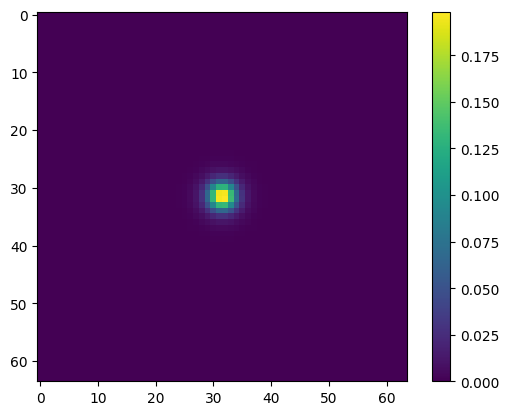

In [10]:
print(np.sum(gal_im.array))

start = time.time()
galsim_conv = galsim.Convolve([gals, psf_obj]).shift(0.5*scale, 0.5*scale).drawImage(nx=64, ny=64, scale=0.168, method='auto')
end = time.time()
print(end-start)

print(np.sum(galsim_conv.array))

plt.imshow(galsim_conv.array)
plt.colorbar()

1.1026859e-06


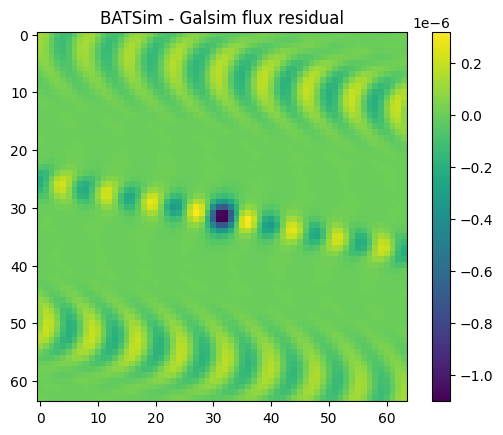

In [11]:
print(np.max(abs(conv_im - galsim_conv.array)))
plt.imshow(conv_im - galsim_conv.array)
plt.colorbar()
plt.title('BATSim - Galsim flux residual')
plt.savefig('conv_diff.png')

In [13]:
hlr = 0.01
flux = 40
nn = 128
init_scale = 0.001

sersic_gal = galsim.Sersic(n=0.5, half_light_radius=hlr, flux=flux)
psf_obj = galsim.Moffat(beta=3.5, fwhm=0.6)
    
mals = np.linspace(1,20,80)

size_ratios = []
centre_residuals = []
interp_time = []
galsim_time = []
for m in mals:
    
    scale = init_scale * m

    im_stamp = batstamp.Stamp(nn=nn, scale=scale, centering='galsim')

    gamma1 = 0.2
    gamma2 = 0.
    kappa = 0.

    mu = 1/((1-kappa)**2 - gamma1**2 - gamma2**2)
    gals = sersic_gal.lens(g1=gamma1, g2=gamma2, mu=mu)
    
    Lens = batforms.LensTransform(gamma1=gamma1, gamma2=gamma2, kappa=kappa, center=None)
    im_stamp.transform_grids(Lens)
    bats = im_stamp.sample_galaxy(sersic_gal)

    start = time.time()

    conv_obj = batstamp.interp_and_convolve(bats, psf_obj, scale)
    interp_conv = conv_obj.drawImage(nx=64, ny=64, scale=0.168, method='sb')

    end = time.time()
    
    interp_time.append(end-start)
    
    start = time.time()

    galsim_conv = galsim.Convolve([gals, psf_obj]).shift(0.5*scale, 0.5*scale).drawImage(nx=64, ny=64, scale=0.168, method='sb')
    
    end = time.time()
    
    galsim_time.append(end-start)

    size_ratio = (nn / 2) * scale / hlr
    size_ratios.append(size_ratio)
    
    residuals = interp_conv.array - galsim_conv.array
    centre_residuals.append(residuals[32,32])

In [15]:
print(abs(np.array(centre_residuals)).min())

0.10242462


0.001


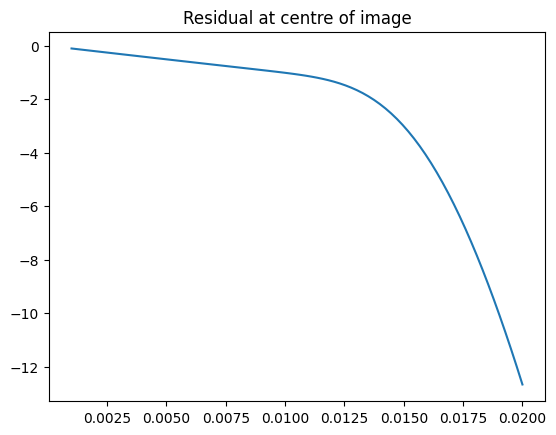

In [12]:
plt.plot(init_scale*mals, centre_residuals)
plt.title('Residual at centre of image')
min_ind = np.argmin(abs(np.array(centre_residuals)))
print(init_scale*mals[min_ind])

Text(0.5, 1.0, 'InterpolatedImage convolution time / GSObject convolution time')

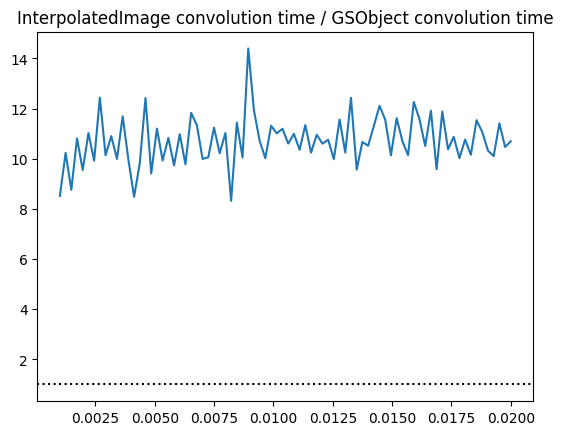

In [11]:
plt.plot(mals*init_scale, np.array(interp_time)/np.array(galsim_time))
plt.axhline(1, c='black', ls=':')
plt.title('InterpolatedImage convolution time / GSObject convolution time')